# Model Evaluation and Interpretation

interpreting the best model using lime and shap

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import shap
import lime
import lime.lime_tabular

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## load model and data

In [154]:
df = pd.read_csv('data_cleaned.csv')

X = df.drop(columns=['Species'])
y = df['Species']

le = joblib.load('label_encoder.pkl')
best_model = joblib.load('best_model.pkl')
split_data = joblib.load('train_test_split.pkl')

X_train = split_data['X_train']
X_test = split_data['X_test']
y_train = split_data['y_train']
y_test = split_data['y_test']

print(f"loaded model: {type(best_model.best_estimator_['classifier']).__name__}")
print(f"best params: {best_model.best_params_}")
print(f"train samples: {len(X_train)}, test samples: {len(X_test)}")
print(f"\ntest set has {X_test.isna().sum().sum()} missing values")
print(f"missing values per feature:")
print(X_test.isna().sum()[X_test.isna().sum() > 0])

loaded model: LogisticRegression
best params: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
train samples: 239, test samples: 103

test set has 7 missing values
missing values per feature:
Sex                  3
Delta 15 N (o/oo)    2
Delta 13 C (o/oo)    2
dtype: int64


## model predictions

In [155]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

print(f"\nverifying pipeline handles missing values:")
preprocessor = best_model.best_estimator_.named_steps['preprocessor']
X_test_transformed = preprocessor.transform(X_test)
print(f"after preprocessing: {np.isnan(X_test_transformed).sum()} NaN values (should be 0)")

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        45
   Chinstrap       1.00      1.00      1.00        21
      Gentoo       1.00      1.00      1.00        37

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103


verifying pipeline handles missing values:
after preprocessing: 0 NaN values (should be 0)


## confusion matrix

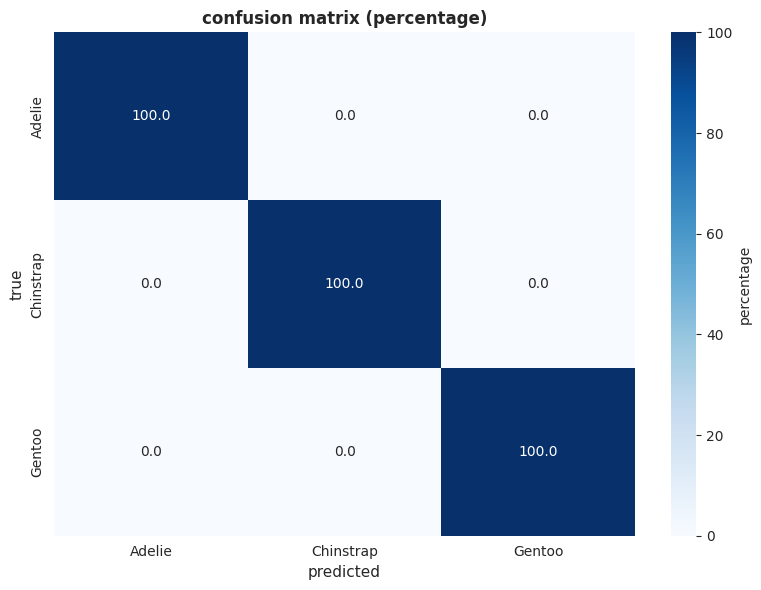

In [156]:
cm = confusion_matrix(y_test, y_pred)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax,
            cbar_kws={'label': 'percentage'})
ax.set_xlabel('predicted', fontsize=11)
ax.set_ylabel('true', fontsize=11)
ax.set_title('confusion matrix (percentage)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## shap values

shap quantifies each feature contribution to predictions

In [157]:
shap.initjs()

explainer = shap.Explainer(best_model.predict, X_train, feature_names=list(X.columns))
shap_values = explainer(X_test)

print(f"computed shap values for {len(X_test)} test samples")

computed shap values for 103 test samples


## shap bar plot

shows mean absolute shap value per feature

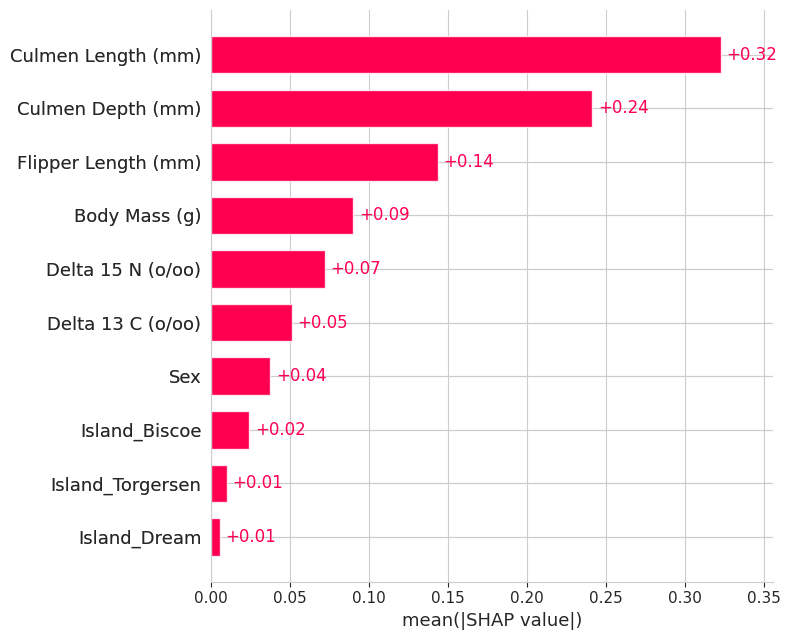

In [158]:
shap.plots.bar(shap_values, max_display=10, show=False)
plt.tight_layout()
plt.savefig('shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()

## shap beeswarm plot

shows distribution of shap values - color indicates feature value (red=high, blue=low)

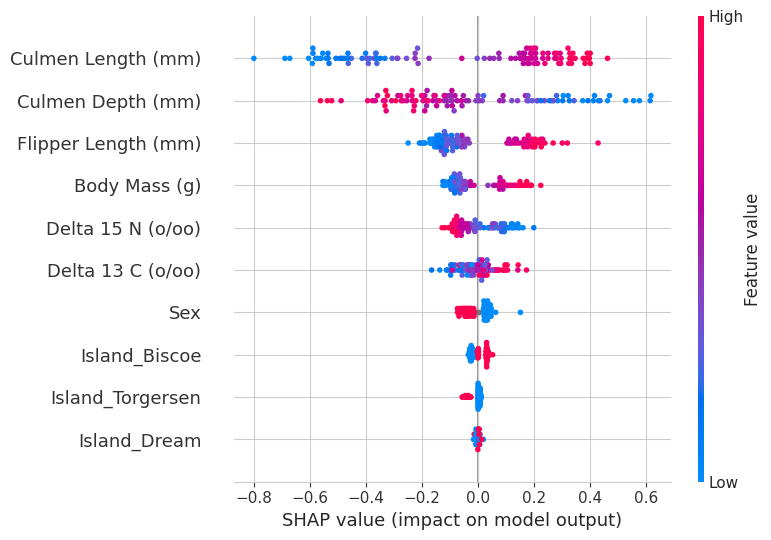

In [159]:
shap.plots.beeswarm(shap_values, max_display=10, show=False)
plt.tight_layout()
plt.savefig('shap_beeswarm.png', dpi=150, bbox_inches='tight')
plt.show()

## shap waterfall plot

shows how features push prediction from base value to final prediction for single sample

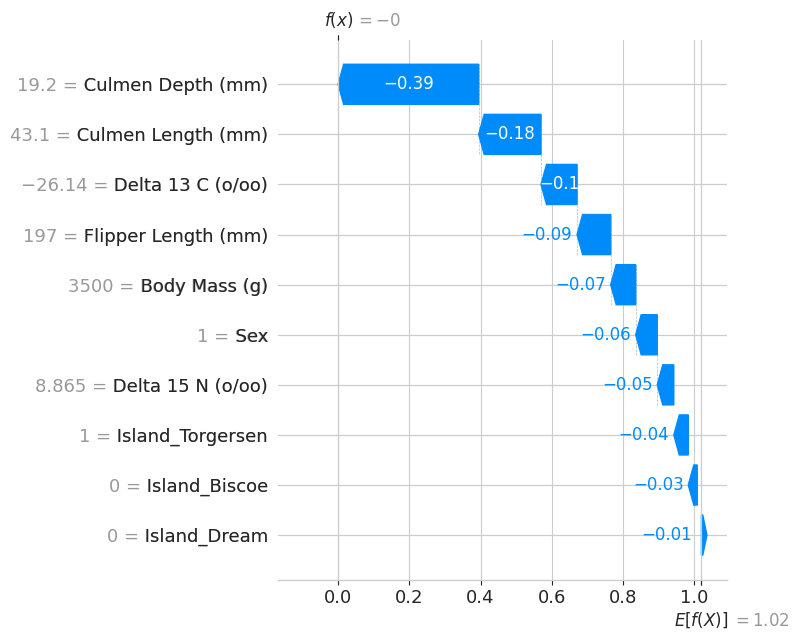

sample 0:
  true species: Adelie
  predicted: Adelie
  probabilities: {'Adelie': np.float64(0.9999384260400058), 'Chinstrap': np.float64(8.728267293533365e-06), 'Gentoo': np.float64(5.284569270081596e-05)}


In [160]:
sample_idx = 0
shap.plots.waterfall(shap_values[sample_idx], max_display=10, show=False)
plt.tight_layout()
plt.savefig('shap_waterfall.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"sample {sample_idx}:")
print(f"  true species: {le.classes_[y_test[sample_idx]]}")
print(f"  predicted: {le.classes_[y_pred[sample_idx]]}")
print(f"  probabilities: {dict(zip(le.classes_, y_pred_proba[sample_idx]))}")

In [161]:
misclassified_indices = np.where(y_test != y_pred)[0]

if len(misclassified_indices) > 0:
    wrong_idx = misclassified_indices[0]
    
    shap.plots.waterfall(shap_values[wrong_idx], max_display=10, show=False)
    plt.tight_layout()
    plt.savefig('shap_waterfall_wrong.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"misclassified sample {wrong_idx}:")
    print(f"  true species: {le.classes_[y_test[wrong_idx]]}")
    print(f"  predicted: {le.classes_[y_pred[wrong_idx]]}")
    print(f"  probabilities: {dict(zip(le.classes_, y_pred_proba[wrong_idx]))}")
    
    print(f"\nraw feature values (before preprocessing):")
    for col in X.columns:
        val = X_test.iloc[wrong_idx][col]
        if pd.isna(val):
            print(f"  {col}: NaN (imputed by pipeline)")
        else:
            print(f"  {col}: {val:.2f}")
    
    preprocessor = best_model.best_estimator_.named_steps['preprocessor']
    X_preprocessed = preprocessor.transform(X_test.iloc[[wrong_idx]])
    print(f"\npreprocessed values (after imputation & scaling):")
    print(f"  {X_preprocessed[0]}")
else:
    print("no misclassified samples found")

no misclassified samples found


## shap waterfall: misclassified sample

analyzing what went wrong in a misclassified prediction

## lime interpretation

lime creates local linear approximations to explain individual predictions

In [162]:
categorical_features_indices = [X.columns.get_loc(col) for col in ['Sex', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']]

def predict_fn(X_input):
    preprocessor = best_model.best_estimator_.named_steps['preprocessor']
    classifier = best_model.best_estimator_.named_steps['classifier']
    X_df = pd.DataFrame(X_input, columns=X.columns)
    X_transformed = preprocessor.transform(X_df)
    return classifier.predict_proba(X_transformed)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=list(X.columns),
    class_names=le.classes_,
    categorical_features=categorical_features_indices,
    mode='classification',
    discretize_continuous=False
)

print(f"created lime explainer")

created lime explainer


## lime explanation for sample

saved lime explanation to lime_explanation.html


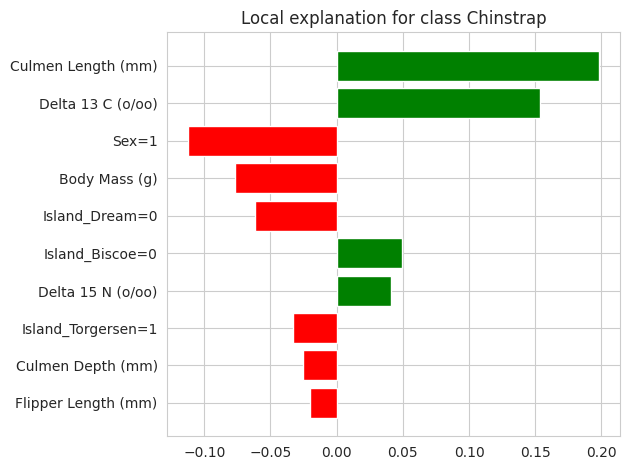


sample 0:
  true species: Adelie
  predicted: Adelie


In [163]:
sample_idx = 0
exp = lime_explainer.explain_instance(
    X_test.iloc[sample_idx].values,
    predict_fn,
    num_features=10
)

exp.save_to_file('lime_explanation.html')
print(f"saved lime explanation to lime_explanation.html")

fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.savefig('lime_explanation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nsample {sample_idx}:")
print(f"  true species: {le.classes_[y_test[sample_idx]]}")
print(f"  predicted: {le.classes_[y_pred[sample_idx]]}")

## lime explanations for different species


explaining Adelie (sample 0)


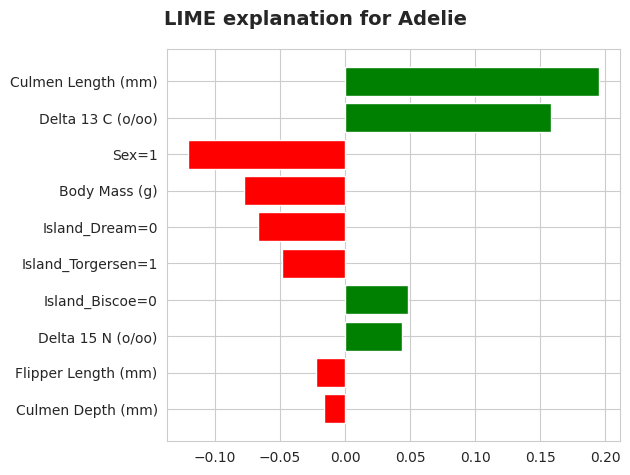

  predicted: Adelie
  probabilities: {'Adelie': np.float64(0.9999384260400058), 'Chinstrap': np.float64(8.728267293533365e-06), 'Gentoo': np.float64(5.284569270081596e-05)}

explaining Chinstrap (sample 2)


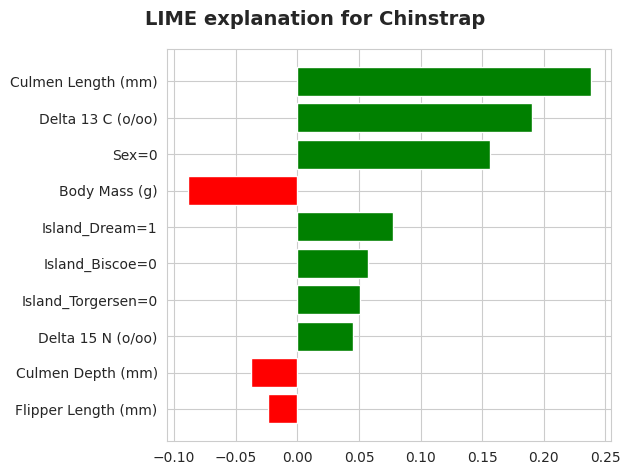

  predicted: Chinstrap
  probabilities: {'Adelie': np.float64(0.01148775222034691), 'Chinstrap': np.float64(0.9884501847738217), 'Gentoo': np.float64(6.206300583138922e-05)}

explaining Gentoo (sample 1)


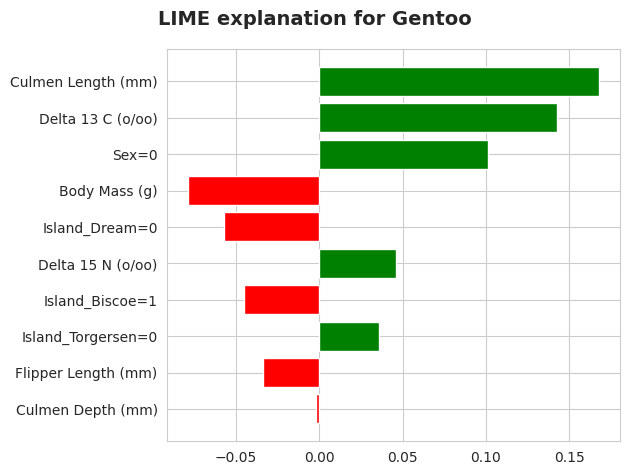

  predicted: Gentoo
  probabilities: {'Adelie': np.float64(0.007789869345646813), 'Chinstrap': np.float64(3.575110985392514e-05), 'Gentoo': np.float64(0.9921743795444992)}


In [164]:
species_samples = {}
for species_idx in range(3):
    idx = np.where(y_test == species_idx)[0][0]
    species_samples[le.classes_[species_idx]] = idx

for species, idx in species_samples.items():
    print(f"\nexplaining {species} (sample {idx})")
    exp = lime_explainer.explain_instance(
        X_test.iloc[idx].values,
        predict_fn,
        num_features=10
    )
    
    fig = exp.as_pyplot_figure()
    
    # Remove the default LIME title and add custom one
    for ax in fig.get_axes():
        ax.set_title('')
    
    fig.suptitle(f'LIME explanation for {species}', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(f'lime_{species.lower()}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  predicted: {le.classes_[y_pred[idx]]}")
    print(f"  probabilities: {dict(zip(le.classes_, y_pred_proba[idx]))}")

## conclusion

